In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.autograd as autograd

import os
import numpy as np
import random
import re
import shutil

In [2]:
#helper functions
def openFile(path):
    f = open(path, "r")
    return f.read() 

def imshow(img,text,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()
    
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


In [3]:
class SiameseLSTM(nn.Module):
    def __init__(self, embedding_dim, hdim, vocab_size):
        super(SiameseLSTM, self).__init__()
        self.hdim = hdim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hdim, num_layers=2).cuda()#, bidirectional=True) #cuda
        
        self.hidden = self.initHidden(self.hdim)
        self.output = nn.Linear(self.hdim, 1)#.cuda()

        
    def initHidden(self, dim):
        return (autograd.Variable(torch.zeros(2, 1, dim)).cuda(), #.cuda()
        autograd.Variable(torch.zeros(2, 1, dim)).cuda())#.cuda())
        
    def forward_once(self, lyric):
        embeds = self.embeddings(lyric)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(lyric), 1, -1), self.hidden) #cuda in embeds
        scores = self.output(lstm_out.view(len(lyric), -1))
        return scores

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
#         print(output1, output2)
        out1 = output1[len(output1)-1]
        out2 = output2[len(output2)-1]
#         return F.softmax(-torch.abs(out1-out2))
        return torch.abs(out1 - out2)

In [4]:
class LyricDataset(Dataset):
    def __init__(self, pathToData, numClasses, should_invert=True):
        self.pathToData = pathToData
        self.data = [path for path in os.listdir(self.pathToData) if os.path.isdir(self.pathToData + "/" + path)]
        self.should_invert = should_invert
        self.numClasses = numClasses
    
    def __getitem__(self, index):
        labels = self.data
        sameClass = random.randint(0,1)
        song1 = None
        song2 = None
        if sameClass: 
            label = random.randint(0, self.numClasses-1)
            classPath = self.pathToData + "/" + labels[label]
            songs = [path for path in os.listdir(classPath) if not path.startswith(".")]
            index1 = random.randint(0,len(songs)-1)
            s1Path = classPath + "/" + songs[index1]
            index2 = index1 
            while index2 == index1:
                index2 = random.randint(0,len(songs)-1)
            s2Path = classPath + "/" + songs[index2]
#             print(songs[index1], songs[index2])

        else:
            label1 = random.randint(0, self.numClasses-1)
            label2 = label1
            while label2 == label1:
                label2 = random.randint(0, self.numClasses-1)
            classPath1 = self.pathToData + "/" + labels[label1]
            songs1 = [path for path in os.listdir(classPath1) if not path.startswith(".")]
            index1 = random.randint(0,len(songs1)-1)
            s1Path = classPath1 + "/" + songs1[index1]
            classPath2 = self.pathToData + "/" + labels[label2]
            songs2 = [path for path in os.listdir(classPath2) if not path.startswith(".")]
            index2 = random.randint(0,len(songs2)-1)
            s2Path = classPath2 + "/" + songs2[index2]
#             print(songs1[index1], songs2[index2])
        s1 = openFile(s1Path)
        lyric1 = [convertForDict(word) for word in s1.split(" ")]
        s2 = openFile(s2Path)
        lyric2 = [convertForDict(word) for word in s2.split(" ")]
        return lyric1, lyric2, sameClass
    
    def __len__(self):
        return sum([len(os.listdir(self.pathToData + "/" + p)) for p in os.listdir(self.pathToData) if p != ".DS_Store"])


In [5]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        return torch.abs(torch.mean(torch.abs(output1-output2))- label)



In [6]:
PATH = "train/taylor_swift"
dataset = LyricDataset(PATH, 2)
dataset

In [7]:
def convertForDict(word):
    pattern = re.compile('[\W_]+')
    word = pattern.sub('', word)
    return word.lower()

def prepare_sequence(seq, to_ix, isTest=False):
    if isTest:
        idxs = []
        for w in seq:
            try:
                idxs.append(to_ix[w] if to_ix[w] != 0 else len(seq)+1)
            except KeyError:
                idxs.append(to_ix["NULL"])
    else:
        idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)#.cuda()

word_to_ix = {}
labels = dataset.data
for artist in labels:
    for song in os.listdir(dataset.pathToData + "/" + artist):
        if song != ".DS_Store":
            for word in openFile(dataset.pathToData + "/" + artist + "/" + song).split(" "):
                word = convertForDict(word)
                if word not in word_to_ix:
                    word_to_ix[word] = len(word_to_ix)
    word_to_ix["NULL"] = len(word_to_ix)
# print(word_to_ix)

In [8]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=3)

In [9]:
counter = []
loss_history = []
avg_loss = []
iteration = 0 

In [10]:
EDIM = 512
HDIM = 512

model = SiameseLSTM(EDIM, HDIM, len(word_to_ix)).cuda()
loss = nn.MSELoss()#.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(5):
    for i, data in enumerate(dataset):
        song1, song2, label = data
        song1, song2 = prepare_sequence(song1, word_to_ix), prepare_sequence(song2, word_to_ix)
        song1, song2 = song1.cuda(), song2.cuda()
        label = Variable(torch.FloatTensor([label]).cuda())
        model.hidden = model.initHidden(HDIM)
        out = model(song1, song2)
        optimizer.zero_grad()
        total_loss = loss(out, label)
        total_loss.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,total_loss.data[0]))
            iteration += 10
            if i > 0:
                counter.append(iteration)
                loss_history.append(total_loss.data[0])
                avg_loss.append((sum(loss_history))/len(loss_history))
        if i == 10:
#             save_checkpoint({
#                 'state_dict': model.state_dict(),
#                 'optimizer': optimizer.state_dict()
#             }, True, filename='saved_models/checkpoint'+ str(epoch) + '.pth.tar')
#             f = open("loss/loss" + str(epoch) + ".txt", "w")
#             [f.write(str(l)) for l in avg_loss]
#             f.close()
            break


Epoch number 0
 Current loss 0.9957210421562195

Epoch number 0
 Current loss 0.00015250373689923435

Epoch number 1
 Current loss 0.00011021696991520002

Epoch number 1
 Current loss 4.870576231041923e-05

Epoch number 2
 Current loss 0.9973542094230652

Epoch number 2
 Current loss 0.9794558882713318

Epoch number 3
 Current loss 0.9986199140548706

Epoch number 3
 Current loss 7.702560651523527e-06

Epoch number 4
 Current loss 7.416519565595081e-06

Epoch number 4
 Current loss 0.9980390071868896



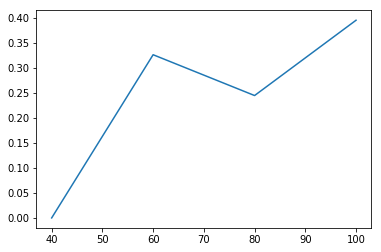

In [11]:
show_plot(counter[1:],avg_loss[1:])

In [12]:
TEST_PATH = "test"
testset = LyricDataset(TEST_PATH, 2)

for i, data in enumerate(testset,0):
    song1, song2, label = data
    song1, song2 = prepare_sequence(song1, word_to_ix, True), prepare_sequence(song2, word_to_ix, True)
    song1, song2 = song1.cuda(), song2.cuda()
    label = Variable(torch.FloatTensor([label]).cuda())
    model.hidden = model.initHidden(HDIM)
    out = model(song1, song2)
    print(label)
    print(out)
    if i == 0:
        break

CuDNNError: 8: b'CUDNN_STATUS_EXECUTION_FAILED'

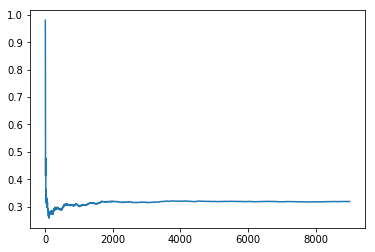

In [31]:
f = open('loss/loss8.txt', 'r')
losses = f.readlines()[0]
losses = losses.replace('0.', ' 0.').split(" ")
losses = [float(l) for l in losses[1:]]
iterations = [i for i in range(len(losses))]
show_plot(iterations, losses)